In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

Using TensorFlow backend.


## Load datasets

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## select appropriate columns for train/test x/y

In [3]:
train_x_raw = train.drop(['species', 'id'], axis=1)
train_y_raw = train['species']
test_x_raw = test.drop(['id'], axis=1)

## preprocess_X makes all the features have $\mu = 0$ and $\sigma = 1$

In [4]:
def preprocess_X(X):
    return (StandardScaler()
        .fit(X)
        .transform(X))

## Preprocess_y turns species strings into one-hot vectors
## It also keeps the label encoder inverse function so you can get the species strings back from the one-hot index

In [5]:
def preprocess_y(y):
    label_encoder = LabelEncoder().fit(y)
    inverse = label_encoder.inverse_transform
    one_hot_y = to_categorical(label_encoder.transform(y))
    return one_hot_y, inverse

## Apply preprocessing

In [6]:
train_x = preprocess_X(train_x_raw)
train_y, label_decoder = preprocess_y(train_y_raw)
test_x = preprocess_X(test_x_raw)

## X is a 990 x 192 matrix.  (number of samples x number of features)

In [7]:
train_x.shape

(990, 192)

## y is a 990 x 99 matrix. (number of samples x number of species)

In [8]:
train_y.shape

(990, 99)

## Here is the keras model
- Single "Dense" layer.
- One "neuron" for each species
- One input for each feature
- "Dense" means each neuron uses every input
- Each "neuron" outputs a weighted sum fed through softmax activation function.  We can interpret this (very roughly) as the probability that the inputs represent a member that neuron's species.


In [9]:
model = Sequential()
model.add(Dense(output_dim=99, input_dim=192))
model.add(Activation('softmax'))

## Here, we define our loss (scoring function) and optimizer (learning algorithm)
### categorical cross_entropy is the same as 'logloss' (which is how kaggle scores this contest)
https://www.kaggle.com/c/leaf-classification/details/evaluation
### 'rmsprop' is a variant of stochastic gradient descent
https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop')

## Fit the model (and keep history so we can plot progress)
- batch_size: number of datapoints considered in one pass at optimizing parmeters
- ephoch: number of times we pass through the entire dataset

http://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [11]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=60, verbose=0)

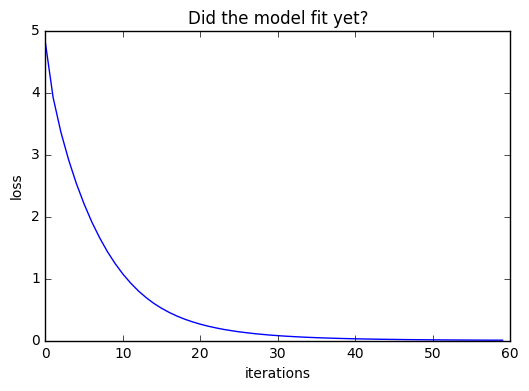

In [12]:
plt.plot(history.history['loss'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Did the model fit yet?')

## Use the model to make predictions

In [13]:
y_predict = model.predict(test_x)

## Generate a csv with our predictions for kaggle

In [14]:
output = pd.DataFrame(y_predict, index=test['id'], columns=[label_decoder(i) for i in range(0, 99)])

In [15]:
output.to_csv('./submission.csv')

# Todo: 
- cross validation
- hyperparameter tuning
- experimenting with multiple layers
- "Dropout" for preventing overfitting.